# Experimentation 

This notebook is simply me testing and seeing the results, I'll try to replicate the results in the paper and build from there, then when i have a better grasp ill start writing a proper problem and solver classes. 



In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Units 
# Q in Å^{-1}
# thickness d 
# roughness sigma in Å
# SLDs rho in Å^{-2}



def kz(Q, rho):
    """
    z-wavevector in a layer for given SLD rho
    """
    return np.sqrt((Q**2)/4.0 - 4.0*np.pi*rho + 0j)  # 0j to allow complex

# an atempt of parratt recursive method for reflecteivity
# http://phys.iit.edu/~segre/phys570/10F/lecture_13.pdf 
def reflectivity(Q, layers, roughness, spin='up', F=None, bkg=0.0):
    sgn = +1 if spin == 'up' else -1 #regular sgn func with spin 
    N = len(layers) - 1  # last is substrate

    rho_s = [L['rho_n'] + sgn * L.get('rho_m', 0.0) for L in layers]
    k = [kz(Q, r) for r in rho_s]

    Gamma = np.zeros_like(Q, dtype=np.complex128)

    for j in range(N-1, -1, -1):
        rj = (k[j] - k[j+1]) / (k[j] + k[j+1])
        sigma = roughness[j] if j < len(roughness) else 0.0
        rj *= np.exp(-2.0 * k[j] * k[j+1] * (sigma**2))

        dj1 = layers[j+1].get('d', 0.0)
        phase = np.exp(2j * k[j+1] * dj1)

        Gamma = (rj + Gamma * phase) / (1.0 + rj * Gamma * phase)

    R = np.abs(Gamma)**2
    if F is not None:
        R = F(Q) * R
    return R + bkg

# Test

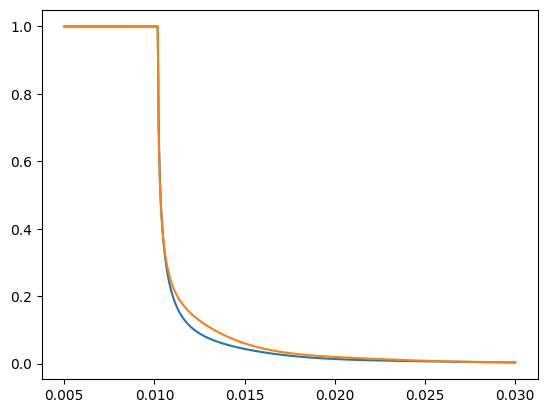

In [4]:
air = {'rho_n': 0.0, 'rho_m': 0.0, 'd': 0.0}
mrl = {'rho_n': 1.0e-6, 'rho_m': 2.0e-6, 'd': 100.0}  # 100 Å
cap = {'rho_n': 3.5e-6, 'rho_m': 0.0,'d': 16.0}
soi = {'rho_n': 2.0e-6, 'rho_m': 0.0,'d': 500.0}
sub = {'rho_n': 2.07e-6,'rho_m': 0.0, 'd': 0.0}   

layers = [air, mrl, cap, soi, sub]
rough = [3.0, 5.0, 8.6, 3.0]  # sigma_air/MRL, sigma_MRL/cap, sigma_cap/SOI, sigma_SOI/sub  (Å)

Q = np.linspace(0.005, 0.03, 1000)  # Å^-1
R_up = reflectivity(Q, layers, rough, spin='up',   bkg=1e-5)
R_down = reflectivity(Q, layers, rough, spin='down', bkg=1e-5)

plt.plot(Q, R_down) 
plt.plot(Q, R_up)
plt.show()   

# Reproducing paper results

In [ ]:
CONST = {
    # nuclear SLDs (Å^-2)
    "rho_n": {
        "Si": 2.07e-6,
        "Ti": -1.95e-6,
        "Co": 2.26e-6,
        "Al2O3": 3.45e-6,
        "SiO2": 3.47e-6,
        "Au": 4.51e-6,
        "Air": 0.0
    },
    "rho_m_Co_sat": 2.7e-6,

    "lambda_A": 4.825,     
    "bkg": 1e-5,   
    "Q_min": 0.005, "Q_max": 0.25, "Q_pts": 2000,

    # default 
    "x_Co": 0.73,   # Co fraction in CoTi
    "d_MRL": 100.0,  # Å
    "sigma_MRL_sub": 5.0,  # Å
    "sigma_MRL_cap": 5.0,  # Å
    "cap_material": "Al2O3",
    "d_cap": 16.0,         # Å
    "sigma_cap_SOI": 8.6,  # Å
    "B_T": 0.020,       # 20 mT
    "B_sat_T": 0.010 
}

SOI_SLDs = [1.0e-6, 2.0e-6, 3.0e-6]
SOI_CASES =   [
    ("thin",   50.0,  15.0), #jist examples
    ("normal", 500.0, 15.0),
    ("rough",  500.0, 50.0),
]
